# Предсказание CTR 2018

https://www.kaggle.com/c/babushka-ctr-2018

Описание файлов

Вам представлены данные поисковых запросов, по которым была показана контекстная реклама одного рекламодателя.

    train.csv - the training set
    test.csv - the test set.

Поля данных

    RowId - идшник для сабмишена
    AveragePosition - средняя позиция объявления на странице выдачи
    CampaignId - рекламная кампания, обычно содежит объявления одной тематики
    AdGroupId  - содержит группу объявлений, которые показываются при совпадении запроса пользователя (Query) с ключевым словом рекламодателя (описывается KeywordId, сами ключевые слова не включены в датасет)


In [242]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [243]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test_upd.csv')

Добавим целевую переменную и бинарную "был клик или нет", дату переделаем в datetime

In [244]:
train['RPC'] = train['Clicks'] / train['Impressions']
train['Clicked'] = train.apply(lambda x: 0 if x['Clicks'] == 0 else 1, axis=1)
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

Посмотрим на данные

In [245]:
train.head()

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks,Impressions,RPC,Clicked
0,150950690,7953835370,116881275,may loan,NEAR_EXACT,HIGH_END_MOBILE,2016-08-26,1.0,1,1,1.0,1
1,150950690,7953835370,116881275,my lloan,NEAR_EXACT,DESKTOP,2016-09-16,1.0,1,1,1.0,1
2,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-05,2.0,1,1,1.0,1
3,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-12,2.0,1,1,1.0,1
4,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-18,1.0,0,1,0.0,0


In [246]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56222 entries, 0 to 56221
Data columns (total 12 columns):
CampaignId                   56222 non-null int64
AdGroupId                    56222 non-null int64
KeywordId                    56222 non-null int64
Query                        56222 non-null object
QueryMatchTypeWithVariant    56222 non-null object
Device                       56222 non-null object
Date                         56222 non-null datetime64[ns]
AveragePosition              56222 non-null float64
Clicks                       56222 non-null int64
Impressions                  56222 non-null int64
RPC                          56222 non-null float64
Clicked                      56222 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 5.1+ MB


In [247]:
test.head()

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Id
0,150950810,24573357890,570188752,wasa kredit,EXACT,HIGH_END_MOBILE,2017-01-13,1.7,0
1,150950810,24573357890,570188752,wasa kredit,EXACT,TABLET,2017-02-09,1.0,1
2,150950810,24573479450,24155728639,marginalen bank,EXACT,DESKTOP,2017-02-07,2.0,2
3,150950810,24573357890,570188752,wasa kredit,EXACT,HIGH_END_MOBILE,2017-01-12,1.9,3
4,150951290,7953845090,29883687951,länsförsäkringar billån,PHRASE,DESKTOP,2017-01-22,1.0,4


In [248]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87807 entries, 0 to 87806
Data columns (total 9 columns):
CampaignId                   87807 non-null int64
AdGroupId                    87807 non-null int64
KeywordId                    87807 non-null int64
Query                        87807 non-null object
QueryMatchTypeWithVariant    87807 non-null object
Device                       87807 non-null object
Date                         87807 non-null datetime64[ns]
AveragePosition              87807 non-null float64
Id                           87807 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 6.0+ MB


Взглянем на то, сколько кампаний проводится, каково их количество и как они распределены в обучающей и тестовой выборке

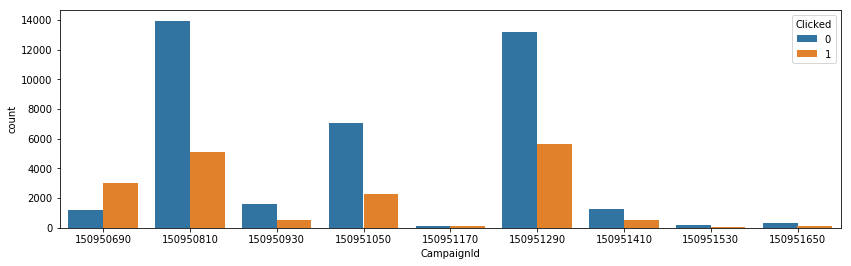

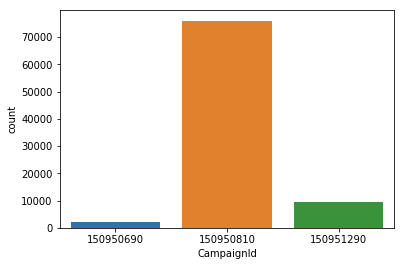

In [249]:
plt.figure(figsize=(14,4))
sns.countplot(x="CampaignId", data=train, hue=train['Clicked'])
plt.show()
sns.countplot(x="CampaignId", data=test)
plt.show()

Можно заметить, что в трейновой выборке 9 кампаний, в тестовой 3, причем эти три являются подмножеством кампаний из трейновой. Возможно, что оставшиеся 6 кампаний вообще не нужны, в дальнейшем это проверим. Кроме того, по рекламам кампании 150950690 кликают чаще, чем не кликают (что странно), и она есть в тестовой выборке. Посмотрим, по каким запросам она показывается

In [250]:
interest_campaign = train.loc[train['CampaignId'] == 150950690]
interest_campaign['Query'].value_counts()[:10]

myloan             1316
my loan             807
mylan               319
my loan sverige     181
myloan se           177
mylån               151
www myloan se       119
my lån              101
myloan omdöme        98
mylone               84
Name: Query, dtype: int64

Люди ищут какой-то MyLoan, видимо какие-то кредиты ¯\_(ツ)_/¯

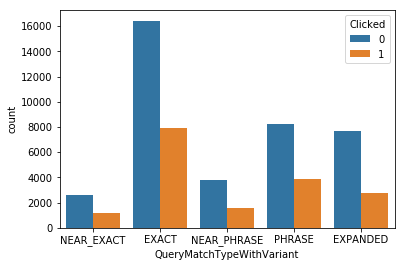

In [251]:
sns.countplot(x="QueryMatchTypeWithVariant", data=train, hue='Clicked')

Посмотрим, что за Expanded (остальные вроде понятны)

In [252]:
train.loc[train['QueryMatchTypeWithVariant'] == 'EXPANDED']

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks,Impressions,RPC,Clicked
2081,150950690,7953835370,44520786825,how much housing loan i can get for my salary,EXPANDED,DESKTOP,2016-09-05,1.0,1,1,1.00,1
2086,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-19,1.0,1,1,1.00,1
2087,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,1,4,0.25,1
2095,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-01-08,1.0,1,1,1.00,1
2096,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-02-03,1.0,0,1,0.00,0
2097,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-21,1.0,1,1,1.00,1
2098,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-22,1.0,1,1,1.00,1
2099,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-07-20,1.0,1,1,1.00,1
2100,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-07-26,1.0,1,1,1.00,1
2101,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-08-13,1.0,1,1,1.00,1


Судя по всему, это запросы, подходящие под тематику рекламы.

Не кликают по такой рекламе примерно так же, как и по другим запросам, видимо ничего интересного тут нет

Посмотрим на девайсы

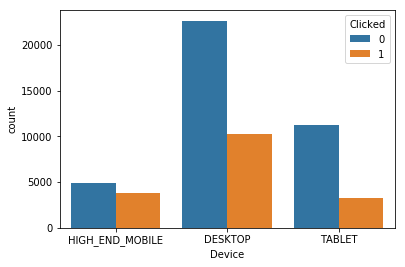

In [253]:
sns.countplot(x="Device", data=train, hue='Clicked')

Интересно, с телефонов кликают чаще, чем с десктопов или планшетов. Можно объяснить размером экрана, но тогда почему с планшетов меньше всего кликов?

Средняя позиция вроде как очевидно должна кореллировать с количеством кликов, проверим

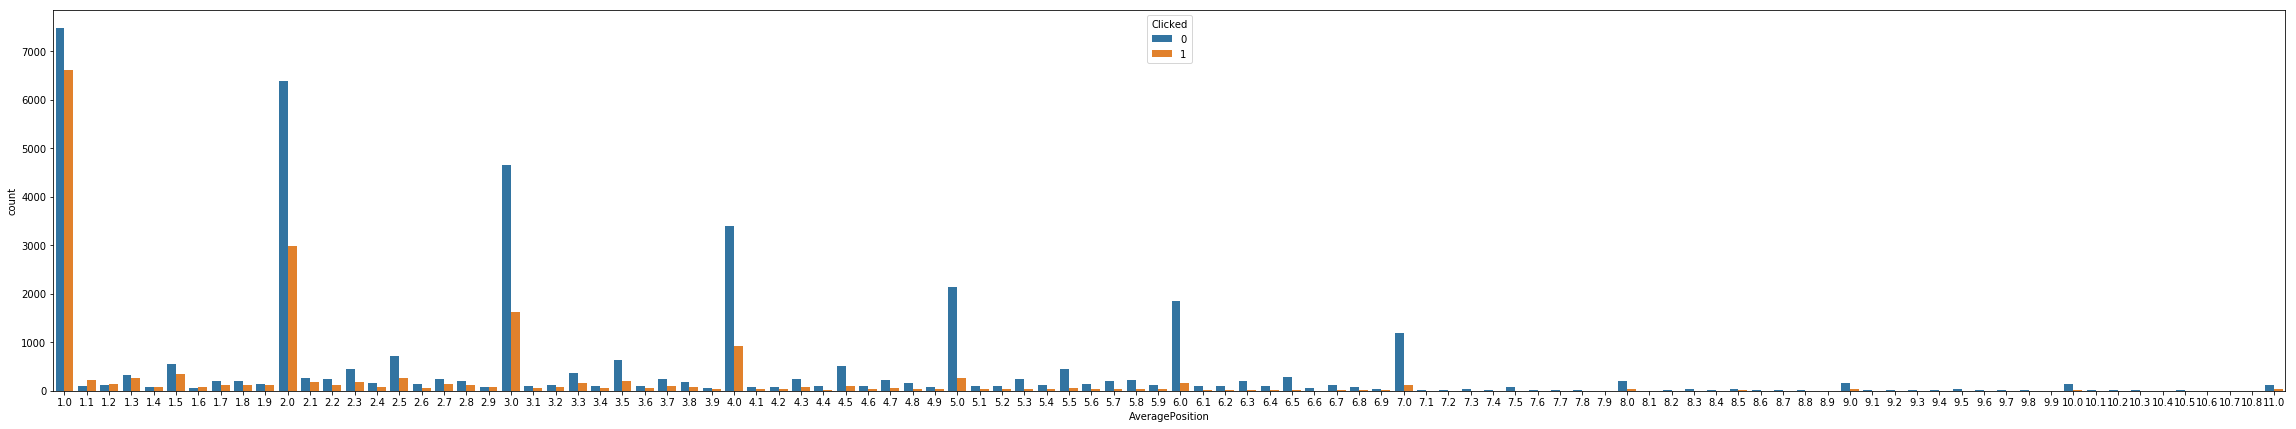

In [254]:
plt.figure(figsize=(40,7))
sns.countplot(x="AveragePosition", data=train, hue='Clicked')

Ну по сути так и есть

Осталось разобраться с датами (возможно, есть какая-то закономерность, хотя вряд ли)

Сбросим лишнее

In [255]:
train.drop(["Query", "Date"], axis=1, inplace=True)
test.drop(["Query", "Date", "Id"], axis=1, inplace=True)

Заэнкодим категориальные переменные (если быть честным, они тут все, кроме кликов и показов, категориальные, но речь про
категориальные-текстовые)

In [256]:
train = pd.get_dummies(train, columns=["QueryMatchTypeWithVariant", 
                                      "Device"])
test = pd.get_dummies(test, columns=["QueryMatchTypeWithVariant", 
                                      "Device"])

In [257]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

test.head()

,CampaignId,AdGroupId,KeywordId,AveragePosition,QueryMatchTypeWithVariant_EXACT,QueryMatchTypeWithVariant_EXPANDED,QueryMatchTypeWithVariant_NEAR_EXACT,QueryMatchTypeWithVariant_NEAR_PHRASE,QueryMatchTypeWithVariant_PHRASE,Device_DESKTOP,Device_HIGH_END_MOBILE,Device_TABLET
0,0.2,9.999927e-01,0.001842,0.116667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.2,9.999927e-01,0.001842,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.2,1.000000e+00,0.093887,0.166667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.2,9.999927e-01,0.001842,0.150000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,5.848501e-07,0.116241,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [258]:
y = train['Clicked']
train.drop(['Clicks', 'RPC', 'Impressions', 'Clicked'], axis=1, inplace=True)

In [259]:
reg = LogisticRegression()
reg.fit(train, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [260]:
pred = reg.predict_proba(test)

In [274]:
print(pred[:,0])

[0.63165558 0.76123878 0.79637512 ... 0.64920681 0.69310327 0.79637512]


In [277]:
def save_prediction(prediction, file_name):
    pd.DataFrame({"Id":list(range(0, 87807)),"ClickProbability":pred[:,0]}).to_csv(file_name,
                                                                                          index=False,header=True)
save_prediction(pred, "dummy.csv")

In [275]:
print(cross_val_score(reg, train, y, cv=3, scoring='neg_log_loss'))

[-0.61651105 -0.82320415 -0.6287025 ]
